In [15]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import gensim
from gensim.models.keyedvectors import KeyedVectors
import nltk
import matplotlib.pyplot as plt
import string
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

data_path = 'data/data.csv'
path = 'data/ru.vec'

tweet_tokenizer = TweetTokenizer()

tweet_data = []

with open(data_path) as f:
    reader = csv.reader(f, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    tweet_data = list(reader)
    
parsed_tweet = []

# stop words
stop = set(stopwords.words('russian'))
model = KeyedVectors.load_word2vec_format(path)

In [9]:
emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)

patt1 = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
patt2 = re.compile(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')

for info in tweet_data:
    # delete links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', unicode(info[0].lower(), 'utf-8'), flags=re.MULTILINE)
    # delete emojis
    text = emoji_pattern.sub(r'', text) # no emoji
    text = patt1.sub(r'', text) # no emoji
    text = patt2.sub(r'', text) # no emoji
    
    # delete @
    # delete #
    l = " ".join(tweet_tokenizer.tokenize(text)).split(" ")
    filtered_sentence = [w for w in l if not w in stop and not w in string.punctuation 
                         and ( w[0] != '@' and w[0] != '#')]
    parsed_tweet.append(filtered_sentence)


word2vec_feature = []

# adds the word2vec average
for tweet in parsed_tweet:
    average_vec = np.zeros(300)
    for word in tweet:
        if word in model.wv:
            average_vec += (model.wv[word] / len(tweet))
        else:
            pass
    word2vec_feature.append(average_vec)
    
# creates a corpus with each document having one string

for i in range(len(parsed_tweet)):
    parsed_tweet[i] = ' '.join(parsed_tweet[i])    

# label the data

tweet_target = np.zeros(len(tweet_data))

labels = {
    'Предложение проституции': 0,
    'Разжигание межнациональной розни': 1,
    'Оскорбление чувств верующих': 2,
    'Посты политической направленности': 3,
    'Продажа наркотиков': 4
}

labels_list = [key for key in labels]
labels_list_two = ['prostitution', 'mezhnac', 'vera', 'politic', 'drugs']


for i in range(len(tweet_data)):
    tweet_target[i] = labels[tweet_data[i][1]]

('\taccuracy test: ', 0.83132530120481929)
[[ 60   0   0   0  10]
 [  0  12   5   7  10]
 [  0   2  30   1   3]
 [  1   9   3  19   2]
 [  3   0   0   0 155]]
              precision    recall  f1-score   support

prostitution       0.94      0.86      0.90        70
     mezhnac       0.52      0.35      0.42        34
        vera       0.79      0.83      0.81        36
     politic       0.70      0.56      0.62        34
       drugs       0.86      0.98      0.92       158

 avg / total       0.82      0.83      0.82       332



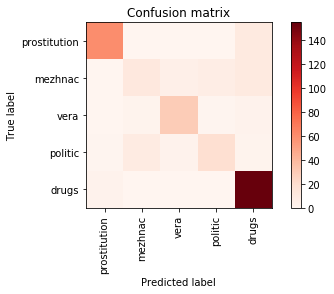

In [11]:
total_svm = 0
""" 
80% Training , 20% Testing
"""

twenty_percent = len(tweet_data) * 0.2


X_train, X_test, y_train, y_test = train_test_split(word2vec_feature, tweet_target, test_size=0.2, random_state=42)

model1 = LinearSVC()
model1.fit(X_train, y_train)

result1 = model1.predict(X_test)

print("\taccuracy test: ", accuracy_score(y_test, result1))

cnf_matrix = confusion_matrix(y_test, result1)
print(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, labels_list_two)

print(classification_report(y_test, result1, target_names=labels_list_two))

In [12]:

errors_first = {i:0 for i in set(y_test)}
errors_second = {i: 0 for i in set(y_test)}
count_documents = {i:0 for i in set(y_test)}

all_size = len(X_test)

# ошибки первого и второго рода
for i in range(len(result1)):
    if(result1[i] != y_test[i]):
        errors_first[result1[i]] += 1
        errors_second[y_test[i]] += 1
    count_documents[y_test[i]] += 1

for i in errors_first:
    # ошибка первого рода, ошибка второго рода, процент категории от общего количества текстов
    print(i, '|', errors_first[i] / float(count_documents[i]) * 100, '%', '|', errors_second[i] /
float(count_documents[i]) * 100, '|', float(count_documents[i]) / all_size * 100)
  

(0.0, '|', 5.714285714285714, '%', '|', 14.285714285714285, '|', 21.084337349397593)
(1.0, '|', 32.35294117647059, '%', '|', 64.70588235294117, '|', 10.240963855421686)
(2.0, '|', 22.22222222222222, '%', '|', 16.666666666666664, '|', 10.843373493975903)
(3.0, '|', 23.52941176470588, '%', '|', 44.11764705882353, '|', 10.240963855421686)
(4.0, '|', 15.822784810126583, '%', '|', 1.89873417721519, '|', 47.59036144578313)


In [13]:
total_svm = 0

# initialize the K-cross fold validation

kf = StratifiedKFold(n_splits=10)

for train_index, test_index in kf.split(word2vec_feature, tweet_target):
    X_train = [word2vec_feature[i] for i in train_index]
    X_test = [word2vec_feature[i] for i in test_index]
    y_train, y_test = tweet_target[train_index], tweet_target[test_index]
    
    model1 = LinearSVC()
    model1.fit(X_train, y_train)
    result1 = model1.predict(X_test)
    
    total_svm = total_svm + sum(y_test == result1)
    

print('AVG K-cross validation: ', float(total_svm)/len(tweet_data))

('AVG K-cross validation: ', 0.8079710144927537)
